In [ ]:
import tensorflow as tf
from tensorflow.python.keras import regularizers
import numpy as np
import random as rn
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras.engine.input_spec import InputSpec
import six
import functools
from tensorflow.python.ops import nn, nn_ops

np.random.seed(1)   
rn.seed(1)   
tf.random.set_seed(1234)

### Циркулянтный свёрточный 2D слой

In [ ]:
def complex_convolution(inputs, kernel):
    '''performs convolution for complex inputs and kernel'''
    inputs_real = tf.dtypes.cast(tf.math.real(inputs), tf.float32)
    inputs_imag = tf.dtypes.cast(tf.math.imag(inputs), tf.float32)
    kernel_real = tf.dtypes.cast(tf.math.real(kernel), tf.float32)
    kernel_imag = tf.dtypes.cast(tf.math.imag(kernel), tf.float32)

    outputs_real = tf.keras.backend.conv2d(inputs_real, kernel_real, [1] * len(inputs.shape), 'same')
    outputs_real -= tf.keras.backend.conv2d(inputs_imag, kernel_imag, [1] * len(inputs.shape), 'same')
    outputs_imag = tf.keras.backend.conv2d(inputs_real, kernel_imag, [1] * len(inputs.shape), 'same')
    outputs_imag += tf.keras.backend.conv2d(inputs_imag, kernel_real, [1] * len(inputs.shape), 'same')

    return tf.complex(outputs_real, outputs_imag)

# @tf.custom_gradient # TODO: if we are adding custom gradient calculation, this is to be used
def fft_convolution(K, inputs, filters): # TODO: add stride, padding and so on
    # getting shapes
    k, _, r, s, n = K.shape
    batch_size, w, h, c0 = inputs.shape

    # padding input to match kernel
    inputs_padding = tf.constant([[0, 0], [0, 0], [0, 0], [0, r * n  - c0]])
    input = tf.pad(inputs, inputs_padding)
    
    # fft along the last dimension
    input_fft_reshape = tf.signal.fft(tf.dtypes.cast(tf.reshape(input, (-1, w, h, r, n)), tf.complex128))
    kernel_fft = tf.signal.fft(tf.dtypes.cast(K, tf.complex128))

    # n (* 4) independent convolutions for complex inputs and kernel
    outputs = []
    # input_fft_reshape = tf.reshape(input_fft, (-1, w, h, r, n))
    for i in range(n):
        Y = complex_convolution(input_fft_reshape[:, :, :, :, i], kernel_fft[:, :, :, :, i])
        outputs.append(Y)

    # stacking outputs
    outputs = tf.stack(outputs)
    outputs = tf.transpose(outputs, [1, 2, 3, 4, 0])

    # ifft & final reshape
    outputs = tf.math.real(tf.signal.ifft(outputs))
    outputs = tf.reshape(outputs, (-1, w, h, s * n))

    # truncating outputs to the filter shape
    outputs = outputs[:, :, :, :filters]

    # TODO: backprop
    # def gradient(dL):

    return outputs

class CircConv2D(tf.keras.layers.Conv2D):
    def __init__(self,
               filters,
               kernel_size,
               n,   # c0 = R * n, c2 = S * n
               strides=(1, 1),
               padding='valid',
               data_format=None,
               dilation_rate=(1, 1),
               activation=None,
               use_bias=True,
               kernel_initializer='glorot_uniform',
               bias_initializer='zeros',
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               **kwargs):
        super(CircConv2D, self).__init__(
               filters=filters,
               kernel_size=kernel_size,
               strides=strides, # doesn't support strides
               padding=padding, # as well as padding
               data_format=data_format,
               dilation_rate=dilation_rate,
               groups=1, # does not support groups!
               activation=activation,
               use_bias=use_bias,
               kernel_initializer=kernel_initializer,
               bias_initializer=bias_initializer,
               kernel_regularizer=kernel_regularizer,
               bias_regularizer=bias_regularizer,
               activity_regularizer=activity_regularizer,
               kernel_constraint=kernel_constraint,
               bias_constraint=bias_constraint,
               **kwargs)
        self.n = n
        self.K = None
        self.bias = None
        self._convolution_op = None

    def build(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape)
        input_channel = self._get_input_channel(input_shape)

        if input_channel < self.n:
            print("input_channel number is less than n, shrinking n forcibly")
            self.n = input_channel
        if self.filters < self.n:
            print("output_channel number is less than n, shrinking n forcibly")
            self.n = self.filters
        r, s = int(np.ceil(input_channel / self.n)), int(np.ceil(self.filters / self.n))

        self.K = self.add_weight(
            name='K',
            shape=(self.kernel_size[0], self.kernel_size[0], r, s, self.n),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            trainable=True,
            dtype=self.dtype)
        
        # the rest is copied from Conv build function
        if self.use_bias:
            self.bias = self.add_weight(
              name='bias',
              shape=(self.filters,),
              initializer=self.bias_initializer,
              regularizer=self.bias_regularizer,
              constraint=self.bias_constraint,
              trainable=True,
              dtype=self.dtype)
        else:
            self.bias = None
        channel_axis = self._get_channel_axis()
        self.input_spec = InputSpec(min_ndim=self.rank + 2,
                                    axes={channel_axis: input_channel})

        # Convert Keras formats to TF native formats.
        if self.padding == 'causal':
            tf_padding = 'VALID'  # Causal padding handled in `call`.
        elif isinstance(self.padding, six.string_types):
            tf_padding = self.padding.upper()
        else:
            tf_padding = self.padding
        tf_dilations = list(self.dilation_rate)
        tf_strides = list(self.strides)
    
        tf_op_name = self.__class__.__name__
        if tf_op_name == 'Conv1D':
            tf_op_name = 'conv1d'  # Backwards compat.

        self._convolution_op = functools.partial(
            nn_ops.convolution_v2,
            strides=tf_strides,
            padding=tf_padding,
            dilations=tf_dilations,
            data_format=self._tf_data_format,
            name=tf_op_name)
        self.built = True

    def call(self, inputs):
        outputs = fft_convolution(self.K, inputs, self.filters)

        if self.use_bias:
            output_rank = outputs.shape.rank
            if self.rank == 1 and self._channels_first:
                # nn.bias_add does not accept a 1D input tensor.
                bias = array_ops.reshape(self.bias, (1, self.filters, 1))
                outputs += bias
            else:
                # Handle multiple batch dimensions.
                if output_rank is not None and output_rank > 2 + self.rank:

                    def _apply_fn(o):
                        return nn.bias_add(o, self.bias, data_format=self._tf_data_format)

                    outputs = nn_ops.squeeze_batch_dims(
                      outputs, _apply_fn, inner_rank=self.rank + 1)
                else:
                    outputs = nn.bias_add(
                      outputs, self.bias, data_format=self._tf_data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs

### Проверка работоспособности слоя на наборе данных из букв (одна из наших домашек)

#### Подготовка данных

In [ ]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_large.tar.gz
!tar -xvf notMNIST_large.tar.gz >> /dev/null

--2021-05-12 19:01:22--  http://yaroslavvb.com/upload/notMNIST/notMNIST_large.tar.gz
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247336696 (236M) [application/x-gzip]
Saving to: ‘notMNIST_large.tar.gz’

notMNIST_large.tar. 100%[===================>] 235.88M  22.1MB/s    in 11s     

2021-05-12 19:01:34 (21.6 MB/s) - ‘notMNIST_large.tar.gz’ saved [247336696/247336696]



In [ ]:
DATA_DIR = 'notMNIST_large/'

In [ ]:
from glob import glob
from PIL import Image
import os

for img_path in glob(f'{DATA_DIR}/**/*.png'):
  try:
    img = Image.open(img_path)
  except:
      os.remove(img_path)

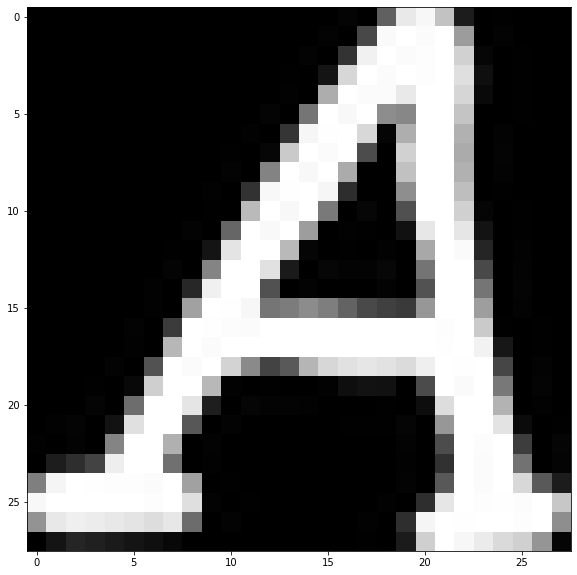

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(17,10))
letter = 'A'
img = cv2.imread(os.path.join(DATA_DIR, letter, os.listdir(f'{DATA_DIR}/{letter}/')[1]))
plt.imshow(img)

In [ ]:
import os
import keras
from keras.models import Sequential
from keras.preprocessing import image
from keras.layers.core import Activation, Reshape, Dense, Flatten
from keras.layers import Conv2D, MaxPool2D, InputLayer, BatchNormalization, Dropout, GlobalAveragePooling2D, GlobalMaxPool2D
from keras.models import Model

pic_size = 28
n_classes = len(os.listdir(DATA_DIR))

def build_model(n):
    print(n_classes)
    model = keras.Sequential([
        CircConv2D(81, 3, n=n,
                        input_shape=(pic_size, pic_size, 3),
                            data_format="channels_last", activation='relu',
                            padding='same'),
        keras.layers.MaxPooling2D(),
        CircConv2D(27, 3, n=n,
                        activation='relu', padding='same'),
        keras.layers.MaxPooling2D(),
        CircConv2D(9, 3, n=n,
                        activation='relu', padding='same'),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# https://stackoverflow.com/questions/53037510/can-flow-from-directory-get-train-and-validation-data-from-the-same-directory-in (самый залайканый ответ)

""" Data generators initialization: for train and validation sets """
generator = ImageDataGenerator(validation_split=0.1, rescale=1./255)
train_gen = generator.flow_from_directory(DATA_DIR,
                                          target_size=(pic_size, pic_size),
                                          class_mode='categorical',
                                          subset='training', seed=1)
val_gen = generator.flow_from_directory(DATA_DIR,
                                        target_size=(pic_size, pic_size),
                                        class_mode='categorical',
                                        subset='validation', seed=1)

Found 476205 images belonging to 10 classes.
Found 52909 images belonging to 10 classes.


#### Модель с обычными свёрточными слоями

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(81, 3, input_shape=(pic_size, pic_size, 3),
                        data_format="channels_last", activation='relu',
                        padding='same'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(27, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(9, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(n_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 81)        2268      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 81)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 27)        19710     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 27)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 9)           2196      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 3, 9)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 81)               

In [ ]:
step_size_train = (train_gen.n // train_gen.batch_size)
step_size_valid = (val_gen.n // val_gen.batch_size)

history = model.fit(train_gen, steps_per_epoch=step_size_train, epochs=2,
                    validation_data=val_gen,
                    validation_steps=step_size_valid)

Epoch 1/2
14881/14881 [==============================] - 155s 10ms/step - loss: 0.4668 - accuracy: 0.8611 - val_loss: 0.2634 - val_accuracy: 0.9209
Epoch 2/2
14881/14881 [==============================] - 155s 10ms/step - loss: 0.3038 - accuracy: 0.9073 - val_loss: 0.2489 - val_accuracy: 0.9236


#### n = 1

In [ ]:
model1 = build_model(1)

10
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
circ_conv2d_9 (CircConv2D)   (None, 28, 28, 81)        2268      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 81)        0         
_________________________________________________________________
circ_conv2d_10 (CircConv2D)  (None, 14, 14, 27)        19710     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 27)          0         
_________________________________________________________________
circ_conv2d_11 (CircConv2D)  (None, 7, 7, 9)           2196      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 9)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 81)            

In [ ]:
step_size_train = (train_gen.n // train_gen.batch_size)
step_size_valid = (val_gen.n // val_gen.batch_size)

history1 = model1.fit(train_gen, steps_per_epoch=step_size_train, epochs=2,
                    validation_data=val_gen,
                    validation_steps=step_size_valid)

Epoch 1/2
14881/14881 [==============================] - 253s 17ms/step - loss: 0.4828 - accuracy: 0.8564 - val_loss: 0.2640 - val_accuracy: 0.9205
Epoch 2/2
14881/14881 [==============================] - 252s 17ms/step - loss: 0.3025 - accuracy: 0.9079 - val_loss: 0.2449 - val_accuracy: 0.9266


#### n = 3

In [ ]:
model3 = build_model(3)

10
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
circ_conv2d (CircConv2D)     (None, 28, 28, 81)        810       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 81)        0         
_________________________________________________________________
circ_conv2d_1 (CircConv2D)   (None, 14, 14, 27)        6588      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 27)          0         
_________________________________________________________________
circ_conv2d_2 (CircConv2D)   (None, 7, 7, 9)           738       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 9)           0         
_________________________________________________________________
flatten (Flatten)            (None, 81)              

In [ ]:
step_size_train = (train_gen.n // train_gen.batch_size)
step_size_valid = (val_gen.n // val_gen.batch_size)

history2 = model3.fit(train_gen, steps_per_epoch=step_size_train, epochs=2,
                    validation_data=val_gen,
                    validation_steps=step_size_valid)

Epoch 1/2
14881/14881 [==============================] - 400s 25ms/step - loss: 0.5386 - accuracy: 0.8391 - val_loss: 0.3197 - val_accuracy: 0.9029
Epoch 2/2
14881/14881 [==============================] - 350s 24ms/step - loss: 0.3571 - accuracy: 0.8912 - val_loss: 0.2807 - val_accuracy: 0.9154


#### n = 10

In [ ]:
model10 = build_model(10)

10
input_channel number is less than n, shrinking n forcibly
output_channel number is less than n, shrinking n forcibly
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
circ_conv2d_3 (CircConv2D)   (None, 28, 28, 81)        810       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 81)        0         
_________________________________________________________________
circ_conv2d_4 (CircConv2D)   (None, 14, 14, 27)        2457      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 27)          0         
_________________________________________________________________
circ_conv2d_5 (CircConv2D)   (None, 7, 7, 9)           252       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 9)           0         


In [ ]:
step_size_train = (train_gen.n // train_gen.batch_size)
step_size_valid = (val_gen.n // val_gen.batch_size)

history2 = model10.fit(train_gen, steps_per_epoch=step_size_train, epochs=2,
                    validation_data=val_gen,
                    validation_steps=step_size_valid)

Epoch 1/2
14881/14881 [==============================] - 561s 37ms/step - loss: 0.5370 - accuracy: 0.8376 - val_loss: 0.3001 - val_accuracy: 0.9100
Epoch 2/2
14881/14881 [==============================] - 554s 37ms/step - loss: 0.3352 - accuracy: 0.8976 - val_loss: 0.2749 - val_accuracy: 0.9166


#### n = c0

In [ ]:
model1000 = build_model(1000)

10
input_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
output_channel number is less than n, shrinking n forcibly
input_channel number is less than n, shrinking n forcibly
output_channel number is less than n, shrinking n forcibly
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
circ_conv2d_6 (CircConv2D)   (None, 28, 28, 81)        810       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 81)        0         
_________________________________________________________________
circ_conv2d_7 (CircConv2D)   (None, 14, 14, 27)        756       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 27)          0         
_________________________________________________________________
circ_conv2d_8 (CircConv

In [ ]:
step_size_train = (train_gen.n // train_gen.batch_size)
step_size_valid = (val_gen.n // val_gen.batch_size)

history3 = model1000.fit(train_gen, steps_per_epoch=step_size_train, epochs=2,
                    validation_data=val_gen,
                    validation_steps=step_size_valid)

Epoch 1/2
14881/14881 [==============================] - 789s 53ms/step - loss: 0.5298 - accuracy: 0.8422 - val_loss: 0.3052 - val_accuracy: 0.9068
Epoch 2/2
14881/14881 [==============================] - 785s 53ms/step - loss: 0.3455 - accuracy: 0.8946 - val_loss: 0.2921 - val_accuracy: 0.9124
